In [1]:
import numpy as np
from prospect.models import priors_beta as pb
from prospect.models import transforms as ts
import matplotlib.pyplot as plt
import lbg_forecast.cosmology as cosmology
import lbg_forecast.sfh as sfh
import lbg_forecast.modified_prospector_beta as mpb


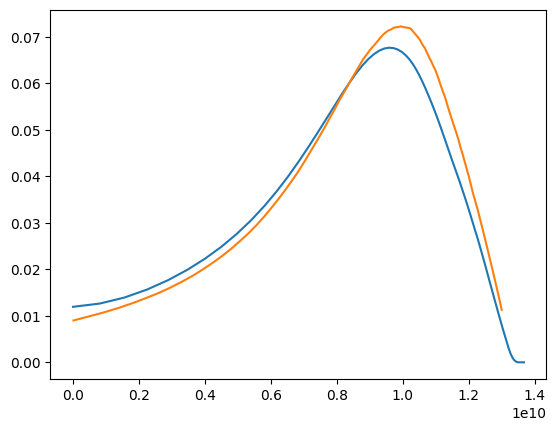

In [11]:
test_z, csfrd_sample= mpb.get_csfrd_prior()
lbtimes, csfrdspl = mpb.get_csfrd_spline(test_z, csfrd_sample)
plt.plot(pb.tl_b19, pb.sfrd_b19)
plt.plot(lbtimes, csfrdspl(lbtimes))

In [12]:
def modified_prospector_beta_sfh_prior(nsamples, redshift, logmass, sigma):
    """Samples log SFR ratios from prospector-beta prior (Wang et al. 2023).
    nbins restricted to nbins=7 for use with sfh.default_agebins().
    """

    dym_sfh =  mpb.ModifiedDymSFHfixZred(zred=redshift,
                mass_mini=logmass-1e-3, mass_maxi=logmass+1e-3,
                z_mini=-1.98, z_maxi=0.19,
                logsfr_ratio_mini=-5.0, logsfr_ratio_maxi=5.0,
                logsfr_ratio_tscale=sigma, nbins_sfh=7,
                const_phi=True)
    
    logsfrratios_samples = np.empty((nsamples, 6))
    for n in range(nsamples):

        samples = dym_sfh.sample()
        logsfrratios = ts.nzsfh_to_logsfr_ratios(samples)
        logsfrratios_samples[n, :] = logsfrratios

    return logsfrratios_samples

Text(0.5, 0, '$t_{L}/t_{\\mathrm{univ}}$')

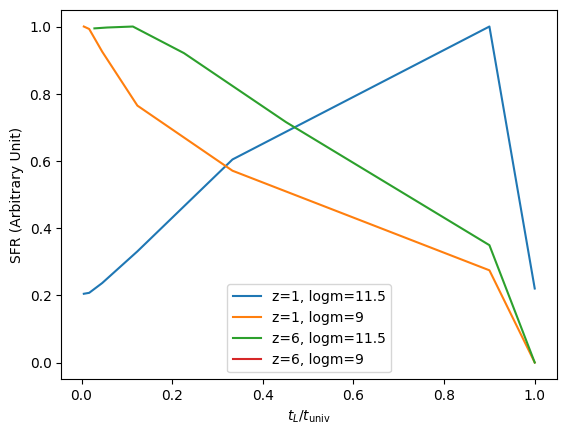

In [57]:
def get_sfr_curve(redshift, logmass):

    sigma = 0.000000000001
    agebins = sfh.default_agebins()

    logsfrratios = modified_prospector_beta_sfh_prior(100, redshift, logmass, sigma)[0, :]

    agebins_pbeta = ts.zred_to_agebins_pbeta(np.array([redshift]), agebins)
    sfrs = ts.logsfr_ratios_to_sfrs(logmass, logsfrratios, agebins_pbeta)
    lookback_time = (10**agebins_pbeta[:, 1])/1e9
    tuniv = cosmology.get_wmap9().age(redshift)

    return lookback_time/tuniv, sfrs


redshift = 1
logmass = 11.5
x1, y1 = get_sfr_curve(redshift, logmass)

redshift = 6
logmass = 11.5
x2, y2 = get_sfr_curve(redshift, logmass)

redshift = 1
logmass = 9
x3, y3 = get_sfr_curve(redshift, logmass)

redshift = 6
logmass = 9
x4, y4 = get_sfr_curve(redshift, logmass)

plt.plot(x1.value, y1/np.max(y1), label="z=1, logm=11.5")
plt.plot(x3.value, y3/np.max(y3), label="z=1, logm=9")
plt.plot(x2.value, y2/np.max(y2), label="z=6, logm=11.5")
plt.plot(x4.value, y4/np.max(y4), label="z=6, logm=9")
plt.legend()

plt.ylabel("SFR (Arbitrary Unit)")
plt.xlabel("$t_{L}/t_{\mathrm{univ}}$")